In [204]:
import os
# os.chdir("../")
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [205]:
import re
import time as ti
import numpy as np                                                              
import pprint
import matplotlib.pyplot as plt
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap
from utils.logger import Logger

In [206]:
class analysis_params():
    model_type = "ica_subspace"
    model_name = "ica_subspace"
    overwrite_analysis = False
    version = "0.0"

analysis_params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params.model_name)
log_file = (analysis_params.model_dir+"/logfiles/"+analysis_params.model_name+"_v"+analysis_params.version+".log")

In [207]:
def plot_weight(w, step, transpose=False, nrows=16, ncols=16):
    if transpose:
        w = np.array(w)[step, : ,:]
    else:
        w = np.array(w)[step, : ,:]
    w  = w / np.linalg.norm(w, ord=2, axis=0)
    fig, ax = plt.subplots(nrows, nrows, figsize=(12, 12))
    vec_i = 0
    for i in range(nrows):
        for j in range(ncols):
            vec = w[:, vec_i].reshape(16 ,16) # should be col vectors
            
            ax[i, j].imshow(vec, cmap="gray")
            ax[i, j].axis('off')
            vec_i += 1
    plt.show()
    

In [208]:
def plot_steps(w, vec_i=0, transpose=False, nrows=4, ncols=4):
    step = len(w)-1
    fig, ax = plt.subplots(nrows, nrows, figsize=(12, 12))
    for i in range(nrows):
        for j in range(ncols):
            if transpose:
                vec = (w[step][vec_i, :] / np.linalg.norm(w[step][vec_i], ord=2)).reshape(16, 16)
            else:
                vec = (w[step][:, vec_i].T / np.linalg.norm(w[step][vec_i].T, ord=2)).reshape(16 ,16) # should be col vectors
            
            ax[i, j].imshow(vec, cmap="gray")
            ax[i, j].axis('off')
            step -= 1
            
            if step == 0:
                plt.show()
                return
    plt.show()

In [209]:
logger = Logger(filename=None)
log_text = logger.load_file(log_file)
model_params = logger.read_params(log_text)[0]
model_schedule = logger.read_schedule(log_text)

In [210]:
pp = pprint.PrettyPrinter(indent=0)
#print("PARAMS")
#pp.pprint(model_params.__dict__)
#print()
#print("SCHEUDLE")
#pp.pprint(model_schedule)

In [211]:
stats = logger.read_stats(log_text)
pp.pprint(stats.keys())

dict_keys(['a_fraction_active', 'a_max_mean_min', 'avg_grad', 'batch_step', 'global_batch_index', 'global_step', 'group_index', 'group_sizes', 'latent_vars', 'number_of_batch_steps', 'schedule_index', 'sum_arr', 'w_analy', 'w_analy_grad_max_mean_min', 'w_synth', 'x_hat_max_mean_min', 'x_max_mean_min', 'z_fraction_active', 'z_max_mean_min'])


In [212]:
print(stats["global_step"][-1])
w_analy = np.array(stats["w_analy"])
w_synth = np.array(stats["w_synth"])
avg_grad = np.array(stats["avg_grad"])

1981


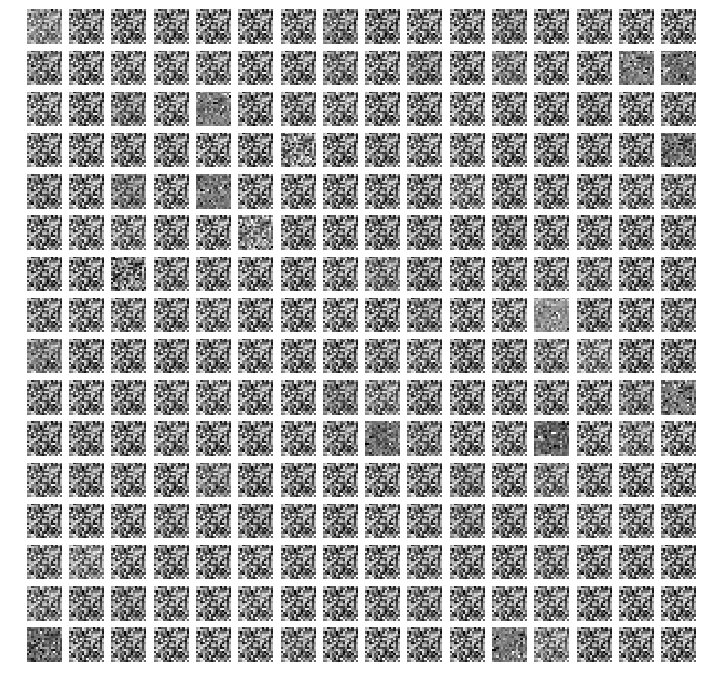

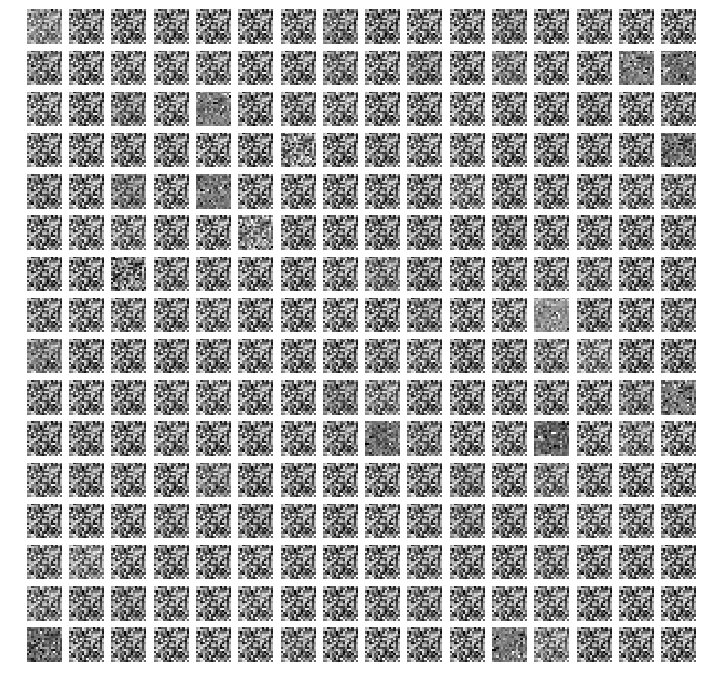

In [213]:
#plot_weight(w_analy, -1)
#plot_weight(w_analy, -1, transpose=True)
plot_weight(w_synth, -1)
plot_weight(w_synth, -1, transpose=True)

In [201]:
np.max(np.linalg.inv(w_analy[99]))

13813.137891669017

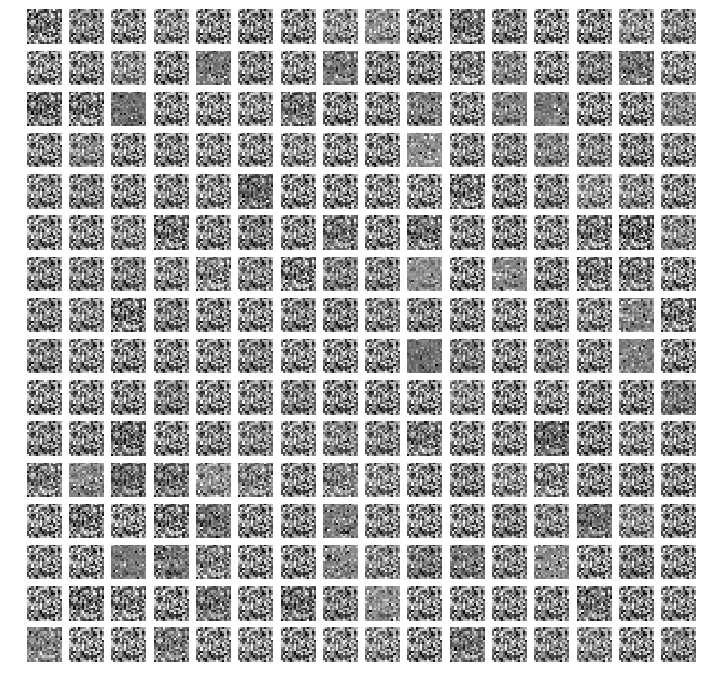

In [202]:
plot_weight(w_synth, 99)

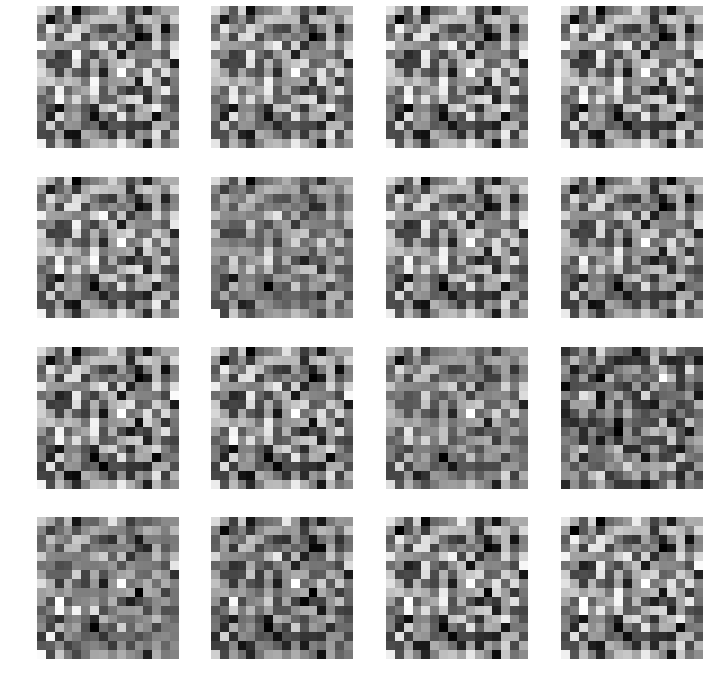

In [203]:
#plot_steps(w_analy, vec_i=3)
plot_steps(w_synth, vec_i=2)
#plot_steps(avg_grad, vec_i=-1)

## Implementation Checks

In [170]:
num_pixels = 256
num_groups = 64
w_init = np.arange(256*256).reshape(256, 256)
model_group_sizes = stats["group_sizes"]
native_group_sizes = [4 for _ in range(num_groups)]

In [171]:
native_group_index = [int(np.sum(native_group_sizes[:i])) for i in range(num_groups)]
#native_group_index

In [172]:
# sum arr (num_dim by num_groups)
sum_arr = []
for g_s, g_i in zip(native_group_sizes, native_group_index):
    g_vec = np.zeros(num_pixels)
    g_vec[g_i:g_i+g_s] += 1
    sum_arr.append(g_vec)
sum_arr = np.float32(np.stack(sum_arr, axis=1))
sum_arr.shape

(256, 64)

In [173]:
p = []
for j in range(64):
    for _ in range(4):
        p.append((j*4, (j*4)+4))

In [174]:
img = np.arange(256).reshape(256, 1)
w = np.random.rand(256, 256)
g = lambda x: x
# native implementation
native_w_grad = np.ones_like(w_init)
group_index = native_group_index
group_index.append(256)
for i in range(256):
    g1, g2 = p[i][0], p[i][1]
    native_w_grad[:, i] = (img * np.dot(w[:, i], img) * g(np.sum(((w.T @ img)**2)[g1:g2]))).reshape(256)
    
# new implementation
wI = (img.T @ w).T
group_scalars = (wI**2).T@sum_arr
nonlinear = sum_arr @ g(group_scalars.T)
scalars = wI * nonlinear
img_tiled = np.tile(img, [1, 256])
new_w_grad = (img_tiled.T * scalars).T


In [175]:
np.allclose(new_w_grad, native_w_grad)

True

In [ ]:
sum_arr[:, 0]

In [ ]:
new_w_grad

In [ ]:
native_w_grad

In [12]:
with tf.Session() as sess:
    x = np.arange(25).reshape(5, 5)
    y = np.array([x for _ in range(100)])
    print(y.shape)
    #print(y)
    print(sess.run(tf.reduce_sum(y, axis=0)))

(100, 5, 5)
[[   0  100  200  300  400]
 [ 500  600  700  800  900]
 [1000 1100 1200 1300 1400]
 [1500 1600 1700 1800 1900]
 [2000 2100 2200 2300 2400]]


In [69]:
with tf.Session() as sess:
    x = np.arange(25).reshape(5, 5)
    print(x)
    y = np.arange(5).reshape(5, 1)
    print(y)
    z = tf.transpose(x)
    print()
    print(sess.run(z))
    print(sess.run(tf.multiply(z, y)))
    print()
    print(sess.run(tf.transpose(tf.multiply(tf.transpose(x), y))))

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[0]
 [1]
 [2]
 [3]
 [4]]

[[ 0  5 10 15 20]
 [ 1  6 11 16 21]
 [ 2  7 12 17 22]
 [ 3  8 13 18 23]
 [ 4  9 14 19 24]]
[[ 0  0  0  0  0]
 [ 1  6 11 16 21]
 [ 4 14 24 34 44]
 [ 9 24 39 54 69]
 [16 36 56 76 96]]

[[ 0  1  4  9 16]
 [ 0  6 14 24 36]
 [ 0 11 24 39 56]
 [ 0 16 34 54 76]
 [ 0 21 44 69 96]]


## Train Model 

In [53]:
import tensorflow as tf
import numpy as np 
import matplotlib
matplotlib.use("Agg")

import params.param_picker as pp
import models.model_picker as mp 
import data.data_selector as ds

import time

import os
# os.chdir("../")
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


/home/ryanchan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  after removing the cwd from sys.path.


In [54]:
# specify model
model_type = "ica_subspace"
data_type = "vanHateren"


## import params
params = pp.get_params(model_type)
params.data_type = data_type
params.data_dir = "/home/ryanchan/datasets"


## import data
data = ds.get_data(params)

## import model and  rocess data
model = mp.get_model(model_type)
data = model.preprocess_dataset(data, params)
data = model.reshape_dataset(data, params)
params.data_shape = list(data["train"].shape[1:])
model.setup(params)

Preprocessing: Low pass filtered train data
Preprocessing: Extracted patches from train data
Preprocessing: Whitened train data
Preprocessing: Normalized train data with maximum
Preprocessing: Normalized train data with maximum
Preprocessing: Centered train data


In [55]:
data_batches = data["train"].next_batch(params.batch_size)
X = data_batches[0]

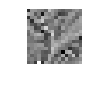

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(1, 1))
plt.imshow(X[45].reshape(16, 16), cmap="gray")
plt.axis('off')
plt.show()

In [ ]:
# setup tensorflow model
config = tf.ConfigProto()
config.gpu_options.allow_growth = True


# train model 
with tf.Session(config=config, graph=model.graph) as sess:
#    sess.run(model.inti_op)
    
    sess.run(model.init_op)
    for sch_idx, sch in enumerate(params.schedule):
        for b_step in range(sch["num_batches"]):
            data_batch = data["train"].next_batch(params.batch_size)
            input_data = data_batch[0]
            input_labels = data_batch[1]

            feed_dict = model.get_feed_dict(input_data, input_labels)
            sess.run(model.apply_grads[sch_idx][0], feed_dict)
            #print("model w synth")
            #print(sess.run(model.w_synth))
            
            if b_step % 10 == 0:
                print("step: {}".format(b_step))
                model.print_update(input_data, input_labels, b_step+1)
                model.generate_plots(input_data, input_labels)

In [ ]:
with tf.Session() as sess:
    x = np.arange(50).reshape(5, 10)
    print(x)
    print()
    print(sess.run(tf.slice(x, [4, 0], [1, 10])))